# Calculate the high vs low years for temperature, ice fraction and nutrietns on a point by point basis using the POP grid... this will take longer, but could potenitally just look nicer?... High vs low years are slected using the 90th and 10th percentile. 
##  Units: 
    1. Temperature ($^o$ C)
    2. Ice Fraction (unitless)
    3. NO$_3$ concentration (mmol m$^{-3}$)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from numpy import arange,array,ones
from scipy import stats
import re 
import os

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Import Phytoplankton biomass information. 

In [5]:
ds = xr.open_mfdataset('/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/pbmss_ch2_1948_2009.nc')

In [6]:
%%time
planktonC = np.stack([ds.ppC_150m_zint, ds.mp1C,ds.diazC, 
                      ds.diat1C, ds.mp2C, ds.diat2C, 
                      ds.mp3C, ds.diat3C, ds.mp4C])

CPU times: user 759 ms, sys: 7.73 s, total: 8.49 s
Wall time: 10.5 s


In [90]:
ds.ppC_150m_zint

<xarray.DataArray 'ppC_150m_zint' (time: 62, month: 12, nlat: 384, nlon: 320)>
dask.array<open_dataset-ppC_150m_zint, shape=(62, 12, 384, 320), dtype=float32, chunksize=(62, 12, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 1948 1949 1950 1951 1952 ... 2005 2006 2007 2008 2009
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [9]:
phytoC_summer_bm = np.nanmean(np.nansum(planktonC[:,:,5:8,:,:],axis=(0)),axis=1)*12000
phytoC_spring_bm = np.nanmean(np.nansum(planktonC[:,:,2:5,:,:],axis=(0)),axis=1)*12000
phytoC_fall_bm = np.nanmean(np.nansum(planktonC[:,:,8:11,:,:],axis=(0)),axis=1)*12000
phytoC_winter_bm = np.nanmean(np.nansum(planktonC[:,:,list(range(2)) + [-1],:,:],axis=(0)),axis=1)*12000

In [10]:
phytoC_summer_bm.shape

(62, 384, 320)

## High vs Low NO$_3$

In [11]:
%%time
file = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009'
NO3_ds_inter = xr.open_mfdataset(f'{file}/NO3_ds_inter_surface.nc');

CPU times: user 11.5 ms, sys: 6.92 ms, total: 18.4 ms
Wall time: 70.8 ms


In [12]:
%%time
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter.NO3,axis=0) # Size (12,384,320)

CPU times: user 449 ms, sys: 729 ms, total: 1.18 s
Wall time: 1.47 s


In [13]:
NO3_ds = np.array(NO3_ds_inter.NO3)

In [14]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,384,320]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

CPU times: user 2.52 s, sys: 124 ms, total: 2.64 s
Wall time: 2.74 s


In [15]:
%%time
no3_arctic_anom_yearly = np.nanmean(no3_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90_no3 = np.empty([384,320]) ; pcen_90_no3[:] = np.nan
pcen_10_no3 = np.empty([384,320]) ; pcen_10_no3[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 14.1 s, sys: 209 ms, total: 14.3 s
Wall time: 14.8 s


In [16]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] < pcen_10_no3[latitude,longitude])
        high_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] > pcen_90_no3[latitude,longitude])

In [17]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_temp = np.empty([12,384,320]) ; low_no3_years_temp[:] = np.nan
high_no3_years_temp = np.empty([12,384,320]) ; high_no3_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

## High vs Low Temperature 

In [18]:
%%time
temp_ds_inter = xr.open_mfdataset(f'{file}/temp_ds_inter_surface.nc');

CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 66.4 ms


In [19]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter.TEMP,axis=0) # Size (384,320)
temp_ds = np.array(temp_ds_inter.TEMP)

In [20]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,384,320]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

CPU times: user 2.4 s, sys: 128 ms, total: 2.52 s
Wall time: 3.45 s


In [21]:
%%time
temp_arctic_anom_yearly = np.nanmean(temp_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90 = np.empty([384,320]) ; pcen_90[:] = np.nan
pcen_10 = np.empty([384,320]) ; pcen_10[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 14.4 s, sys: 2.06 s, total: 16.5 s
Wall time: 17.1 s


In [22]:
%%time
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_temp_years_arctic = {}
high_temp_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_temp_years_arctic = multi_dict(2, int)
high_temp_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] < pcen_10[latitude,longitude])
        high_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] > pcen_90[latitude,longitude])

CPU times: user 727 ms, sys: 36.8 ms, total: 764 ms
Wall time: 791 ms


In [23]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years_temp = np.empty([12,384,320]) ; cold_years_temp[:] = np.nan
warm_years_temp = np.empty([12,384,320]) ; warm_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        cold_years_temp[:,latitude,longitude] = np.nanmean(temp_ds[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        warm_years_temp[:,latitude,longitude] = np.nanmean(temp_ds[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

CPU times: user 9.8 s, sys: 31.4 ms, total: 9.83 s
Wall time: 10.1 s


## High vs Low ICE Fraction Years

In [24]:
%%time
ECOSYS_IFRAC_ds_inter = xr.open_mfdataset(f'{file}/ECOSYS_IFRAC_ds_inter_surface.nc');

CPU times: user 13.9 ms, sys: 298 µs, total: 14.2 ms
Wall time: 54.9 ms


In [25]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC,axis=0) # Size (12,384,320)
ECOSYS_IFRAC_ds = np.array(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC)

In [26]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,384,320]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

CPU times: user 2.35 s, sys: 600 ms, total: 2.95 s
Wall time: 3.04 s


In [27]:
ice_arctic_anom_yearly = np.nanmean(ice_arctic_anom,axis=1) # size is now (62,180,360)

# Create empty arrays filled with NaN's 
pcen_90_ice = np.empty([384,320]) ; pcen_90_ice[:] = np.nan
pcen_10_ice = np.empty([384,320]) ; pcen_10_ice[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

In [28]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] < pcen_10_ice[latitude,longitude])
        high_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] > pcen_90_ice[latitude,longitude])

In [29]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_ice_years_temp = np.empty([12,384,320]) ; low_ice_years_temp[:] = np.nan
high_ice_years_temp = np.empty([12,384,320]) ; high_ice_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 

## Plot phytoplankton biomass interannually 

## NO$_3$

In [48]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([384,320]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([384,320]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([384,320]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([384,320]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([384,320]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([384,320]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([384,320]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([384,320]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_no3_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(phytoC_spring_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(phytoC_spring_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_no3_years_winter[latitude,longitude]= np.nanmean(phytoC_winter_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(phytoC_winter_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 37.3 s, sys: 71.8 ms, total: 37.4 s
Wall time: 39.2 s


## Temperature 

In [49]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([384,320]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([384,320]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([384,320]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([384,320]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([384,320]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([384,320]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([384,320]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([384,320]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_temp_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(phytoC_spring_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(phytoC_spring_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_temp_years_winter[latitude,longitude]= np.nanmean(phytoC_winter_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(phytoC_winter_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

## Ice Fraction

In [50]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([384,320]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([384,320]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([384,320]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([384,320]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([384,320]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([384,320]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([384,320]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([384,320]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_ice_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(phytoC_spring_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(phytoC_spring_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_ice_years_winter[latitude,longitude]= np.nanmean(phytoC_winter_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(phytoC_winter_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 35.5 s, sys: 71 ms, total: 35.5 s
Wall time: 37.1 s


In [51]:
## Import POP grid information 
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
dss= xr.open_mfdataset(files,combine='by_coords')

In [52]:
import cartopy.crs as ccrs
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

In [53]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${}'.format(a, b)


# We want just the summer and the winter, for defense presentation

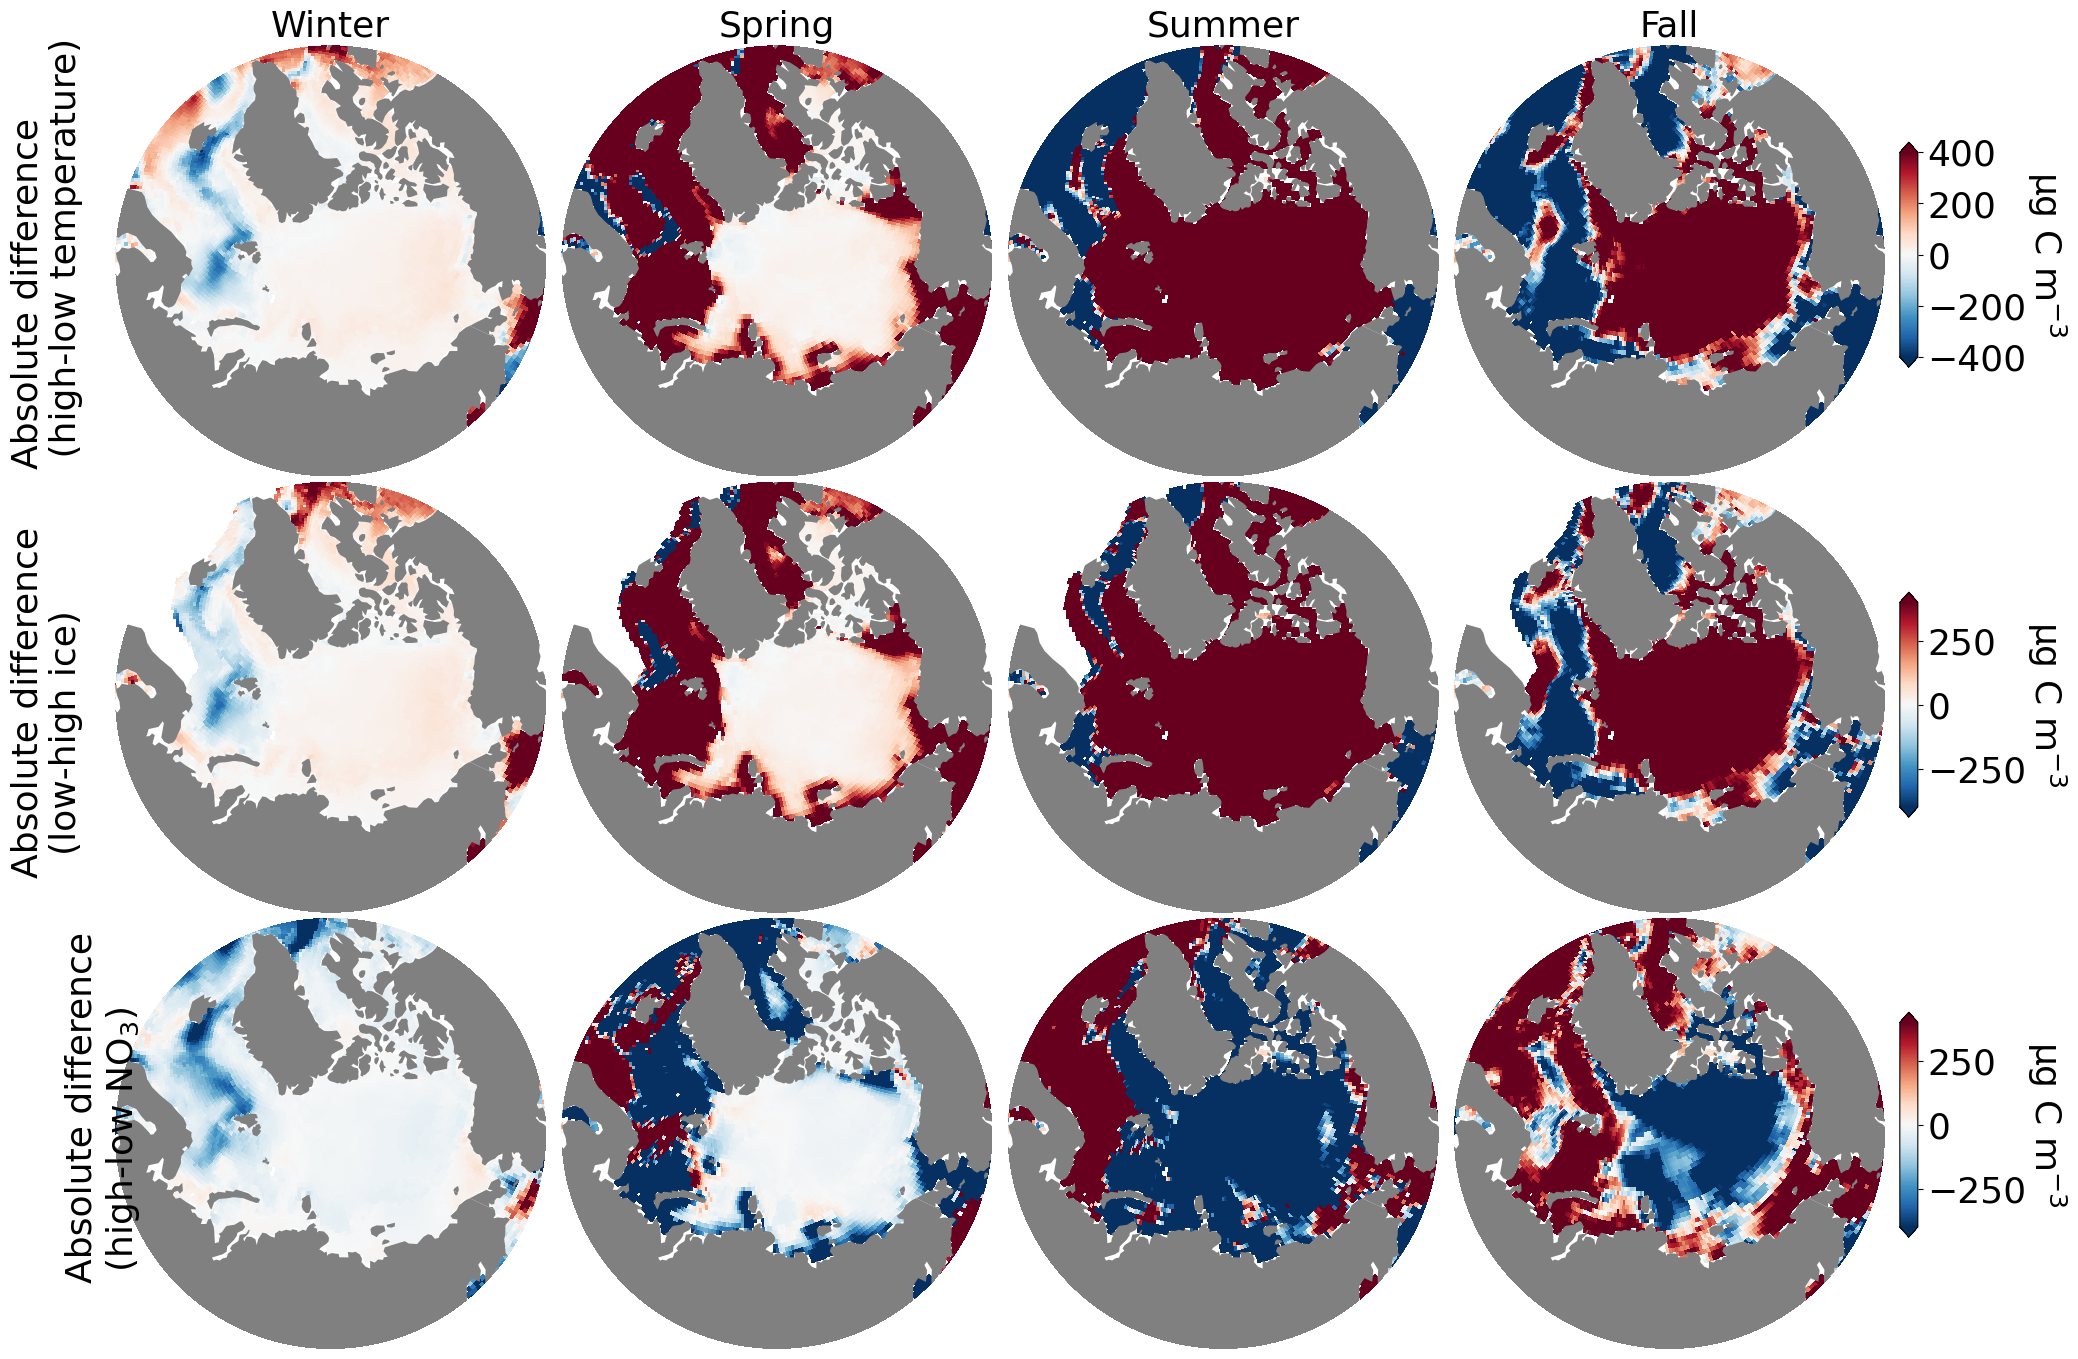

In [54]:
#---------------------------------------------------------------------
fig = plt.figure(figsize=(18, 15))
#---------------------------------------------------------------------
x_lon = dss.TLONG
y_lat= dss.TLAT
font=26

#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())

# -------------  Temperature  ---------------------------------------
vminn = -400
vmaxx = 400
ax = fig.add_subplot(3, 4, 1,projection=my_projn)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_temp_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Winter', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 2,projection=my_projn)
spring_temp_diff = high_temp_years_spring-low_temp_years_spring
x, y, sp_diff = adjust_pop_grid(x_lon, y_lat, spring_temp_diff)
ax.set_title('Spring', fontsize =font)
cf = ax.pcolormesh(x, y, sp_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 3,projection=my_projn)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_temp_diff)
ax.set_title('Summer', fontsize =font)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 4,projection=my_projn)
fall_temp_diff = high_temp_years_fall-low_temp_years_fall
x, y, f_diff = adjust_pop_grid(x_lon, y_lat, fall_temp_diff)
ax.set_title('Fall', fontsize =font)
cf = ax.pcolormesh(x, y, f_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.72, 0.01, 0.15])
ticks = np.linspace(vminn, vmaxx, 5, endpoint=True)
cb = fig.colorbar(cf, ticks=ticks,shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('$\mu$g C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)

#-------------------------------------------------------------------------
#          Ice Fraction 
#-------------------------------------------------------------------------
ax = fig.add_subplot(3, 4, 5,projection=my_projn)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_ice_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 6,projection=my_projn)
spring_ice_diff = low_ice_years_spring-high_ice_years_spring
x, y, sp_diff = adjust_pop_grid(x_lon, y_lat, spring_ice_diff)
cf = ax.pcolormesh(x, y, sp_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 7,projection=my_projn)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_ice_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 8,projection=my_projn)
fall_ice_diff = low_ice_years_fall-high_ice_years_fall
x, y, f_diff = adjust_pop_grid(x_lon, y_lat, fall_ice_diff)
cf = ax.pcolormesh(x, y, f_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
cbar_ax = fig.add_axes([0.9999, 0.42, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('$\mu$g C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
#-------------------------------------------------------------------------
#           NO3  
#-------------------------------------------------------------------------
ax = fig.add_subplot(3, 4, 9,projection=my_projn)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_no3_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 10,projection=my_projn)
spring_no3_diff = high_no3_years_spring-low_no3_years_spring
x, y, sp_diff = adjust_pop_grid(x_lon, y_lat, spring_no3_diff)
cf = ax.pcolormesh(x, y, sp_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 11,projection=my_projn)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_no3_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 12,projection=my_projn)
fall_no3_diff = high_no3_years_fall-low_no3_years_fall
x, y, f_diff = adjust_pop_grid(x_lon, y_lat, fall_no3_diff)
cf =  ax.pcolormesh(x, y, f_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0001,
    hspace=-0.4)

cbar_ax = fig.add_axes([0.9999, 0.14, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1,extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('$\mu$g C m$^{-3}$', fontsize =font,rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
fig.text(-0.05, 0.8, 'Absolute difference \n (high-low temperature) ', va='center', rotation='vertical',fontsize=font)
fig.text(-0.05, 0.5, 'Absolute difference \n  (low-high ice)', va='center', rotation='vertical',fontsize=font)
fig.text(-0.02, 0.23, 'Absolute difference \n (high-low NO$_3$)', va='center', rotation='vertical',fontsize=font)
fig.tight_layout()
#-------------------------------------------------------------------------
#                             SAVE FIGURE 
#-------------------------------------------------------------------------

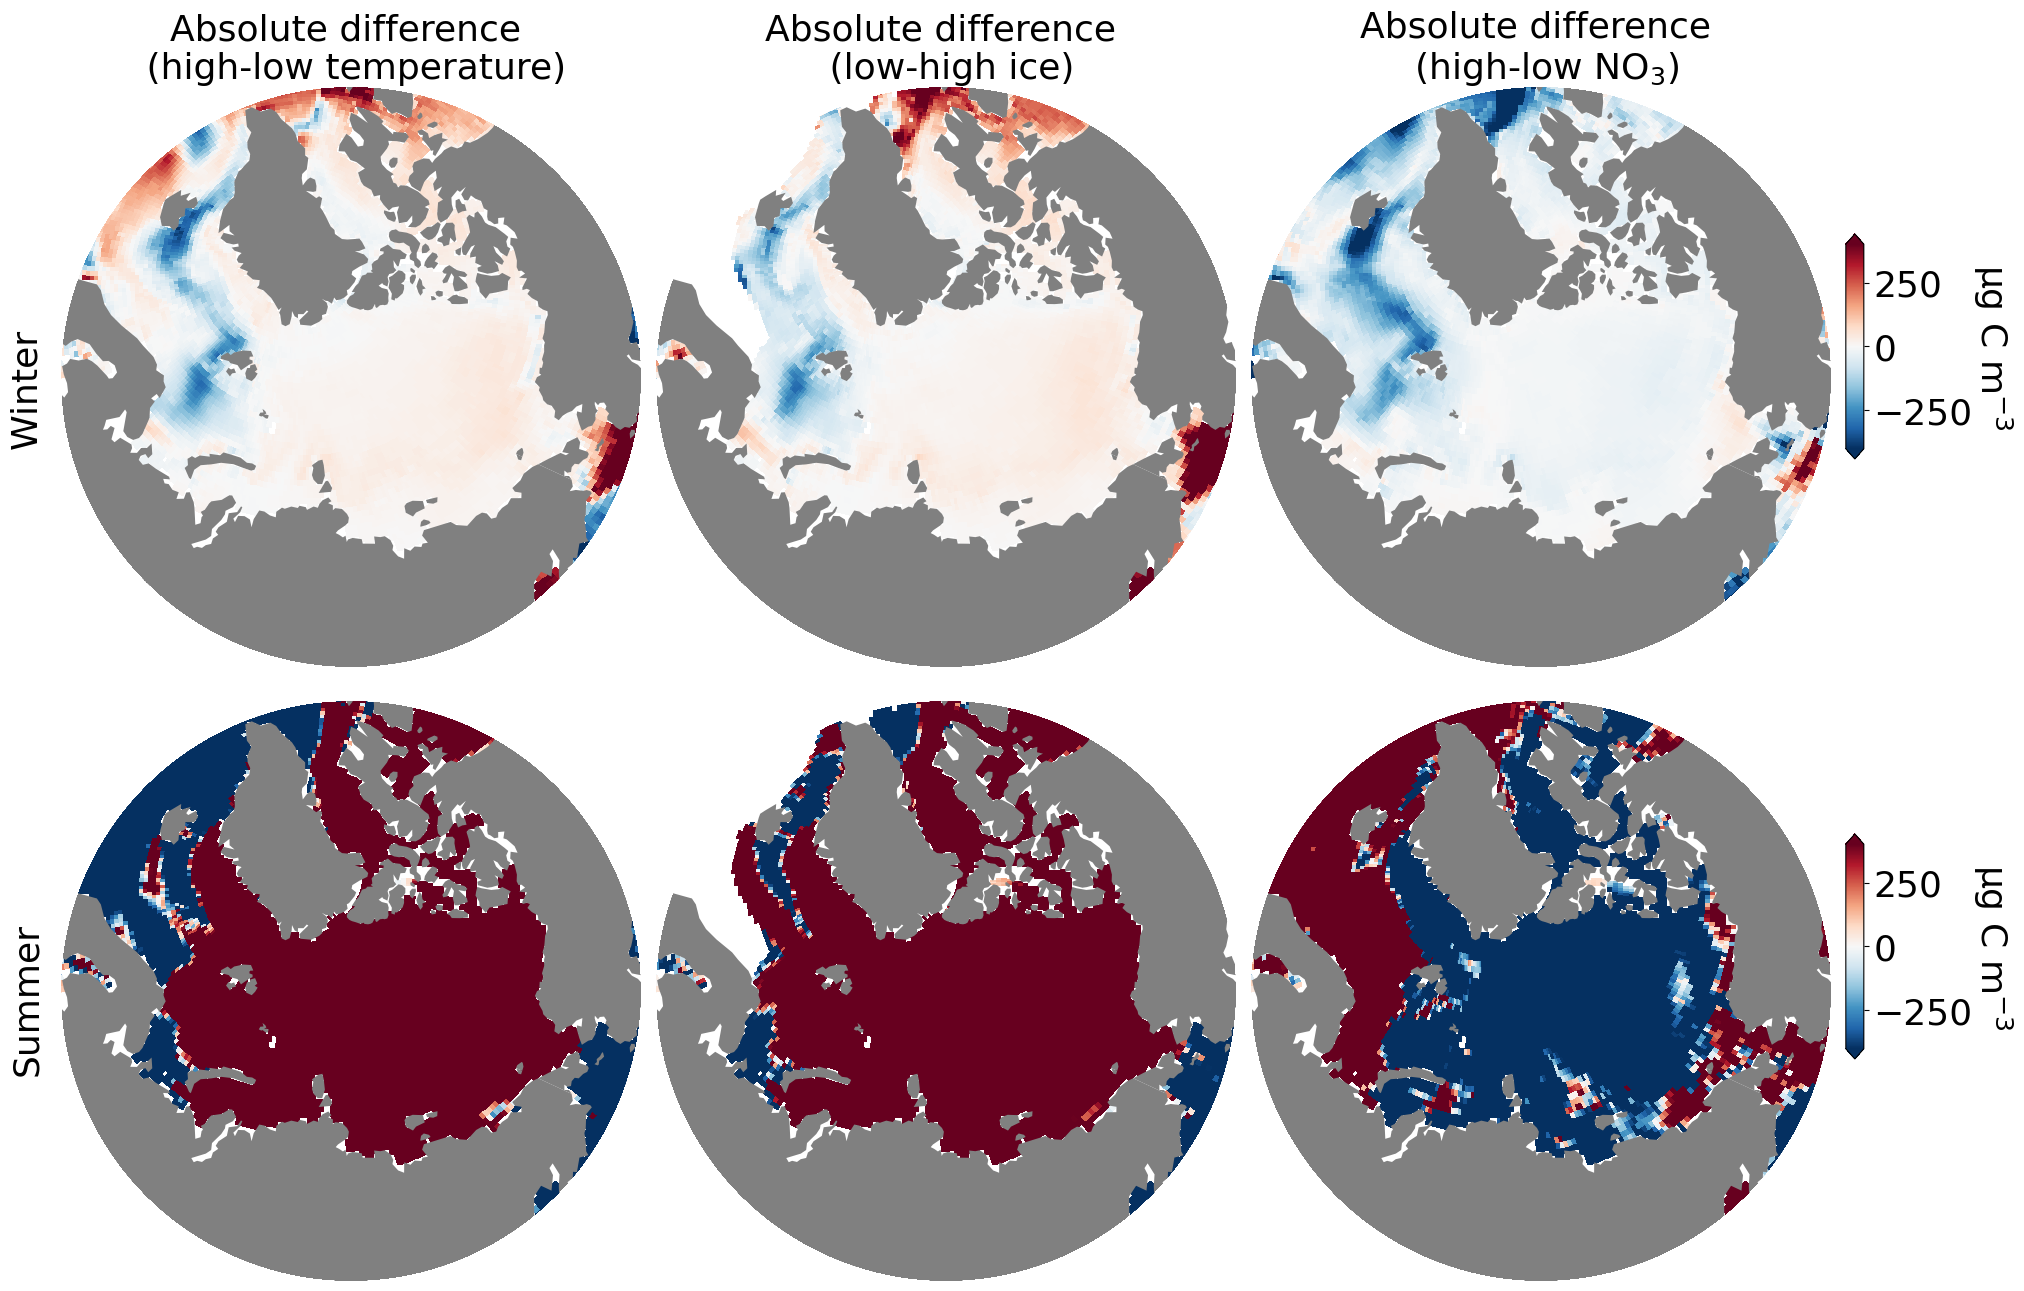

In [55]:
#---------------------------------------------------------------------
fig = plt.figure(figsize=(18, 15))
#---------------------------------------------------------------------
x_lon = dss.TLONG
y_lat= dss.TLAT
font=26

#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())

# -------------  Temperature  ---------------------------------------
vminn = -400
vmaxx = 400
ax = fig.add_subplot(2, 3, 1,projection=my_projn)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_temp_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (high-low temperature)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(2, 3, 4,projection=my_projn)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_temp_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.65, 0.01, 0.15])
cb = fig.colorbar(cf,shrink=0.3, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('$\mu$g C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)

#-------------------------------------------------------------------------
#          Ice Fraction 
#-------------------------------------------------------------------------
ax = fig.add_subplot(2, 3, 2,projection=my_projn)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_ice_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (low-high ice)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(2, 3, 5,projection=my_projn)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_ice_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.25, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.3, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('$\mu$g C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
#-------------------------------------------------------------------------
#           NO3  
#-------------------------------------------------------------------------
ax = fig.add_subplot(2, 3, 3,projection=my_projn)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_no3_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (high-low NO$_3$)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame


ax = fig.add_subplot(2, 3, 6,projection=my_projn)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_no3_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame


plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0001,
    hspace=-0.4)

fig.text(-0.02, 0.7, 'Winter ', va='center', rotation='vertical',fontsize=font)
fig.text(-0.02, 0.29, 'Summer', va='center', rotation='vertical',fontsize=font)
fig.tight_layout()
#-------------------------------------------------------------------------
#                             SAVE FIGURE 
#-------------------------------------------------------------------------
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/summer_winter_phyto_biomass_interannual_percentile_diff_POPgrid.png',dpi=600, bbox_inches='tight')

## Load zooplankton biomass 

In [60]:
file

'/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009'

In [40]:
ds_zoo1= xr.open_mfdataset(f'{file}/zoo1C_62yr_monthly_150m.nc')
ds_zoo2= xr.open_mfdataset(f'{file}/zoo2C_62yr_monthly_150m.nc')
ds_zoo3= xr.open_mfdataset(f'{file}/zoo3C_62yr_monthly_150m.nc')
ds_zoo4= xr.open_mfdataset(f'{file}/zoo4C_62yr_monthly_150m.nc')
ds_zoo5= xr.open_mfdataset(f'{file}/zoo5C_62yr_monthly_150m.nc')
ds_zoo6= xr.open_mfdataset(f'{file}/zoo6C_62yr_monthly_150m.nc')

In [41]:
%%time
zooC = np.stack([ds_zoo1.zoo1C_150m, ds_zoo2.zoo2C_150m, 
                      ds_zoo3.zoo3C_150m, ds_zoo4.zoo4C_150m, ds_zoo5.zoo5C_150m, ds_zoo6.zoo6C_150m])

CPU times: user 1.73 s, sys: 1min 11s, total: 1min 13s
Wall time: 1min 19s


In [43]:
zoo_summer = np.nanmean(np.nansum(zooC[:,:,5:8,:,:],axis=(0)),axis=1)
zoo_spring = np.nanmean(np.nansum(zooC[:,:,2:5,:,:],axis=(0)),axis=1)
zoo_fall = np.nanmean(np.nansum(zooC[:,:,8:11,:,:],axis=(0)),axis=1)
zoo_winter = np.nanmean(np.nansum(zooC[:,:,list(range(2)) + [-1],:,:],axis=(0)),axis=1)

## Zoo NO$_3$

In [44]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([384,320]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([384,320]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([384,320]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([384,320]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([384,320]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([384,320]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([384,320]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([384,320]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(zoo_summer[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_no3_years_summer[latitude,longitude] = np.nanmean(zoo_summer[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(zoo_spring[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(zoo_spring[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(zoo_fall[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(zoo_fall[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_no3_years_winter[latitude,longitude]= np.nanmean(zoo_winter[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(zoo_winter[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 33.7 s, sys: 240 ms, total: 34 s
Wall time: 44.7 s


## Zoo Temperature

In [45]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([384,320]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([384,320]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([384,320]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([384,320]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([384,320]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([384,320]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([384,320]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([384,320]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(zoo_summer[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_temp_years_summer[latitude,longitude] = np.nanmean(zoo_summer[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(zoo_spring[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(zoo_spring[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(zoo_fall[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(zoo_fall[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_temp_years_winter[latitude,longitude]= np.nanmean(zoo_winter[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(zoo_winter[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 32.8 s, sys: 46.4 ms, total: 32.8 s
Wall time: 34.5 s


## Zoo Ice Fraction

In [46]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([384,320]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([384,320]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([384,320]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([384,320]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([384,320]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([384,320]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([384,320]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([384,320]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(zoo_summer[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_ice_years_summer[latitude,longitude] = np.nanmean(zoo_summer[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(zoo_spring[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(zoo_spring[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(zoo_fall[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(zoo_fall[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_ice_years_winter[latitude,longitude]= np.nanmean(zoo_winter[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(zoo_winter[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 31.4 s, sys: 73.2 ms, total: 31.4 s
Wall time: 32.3 s


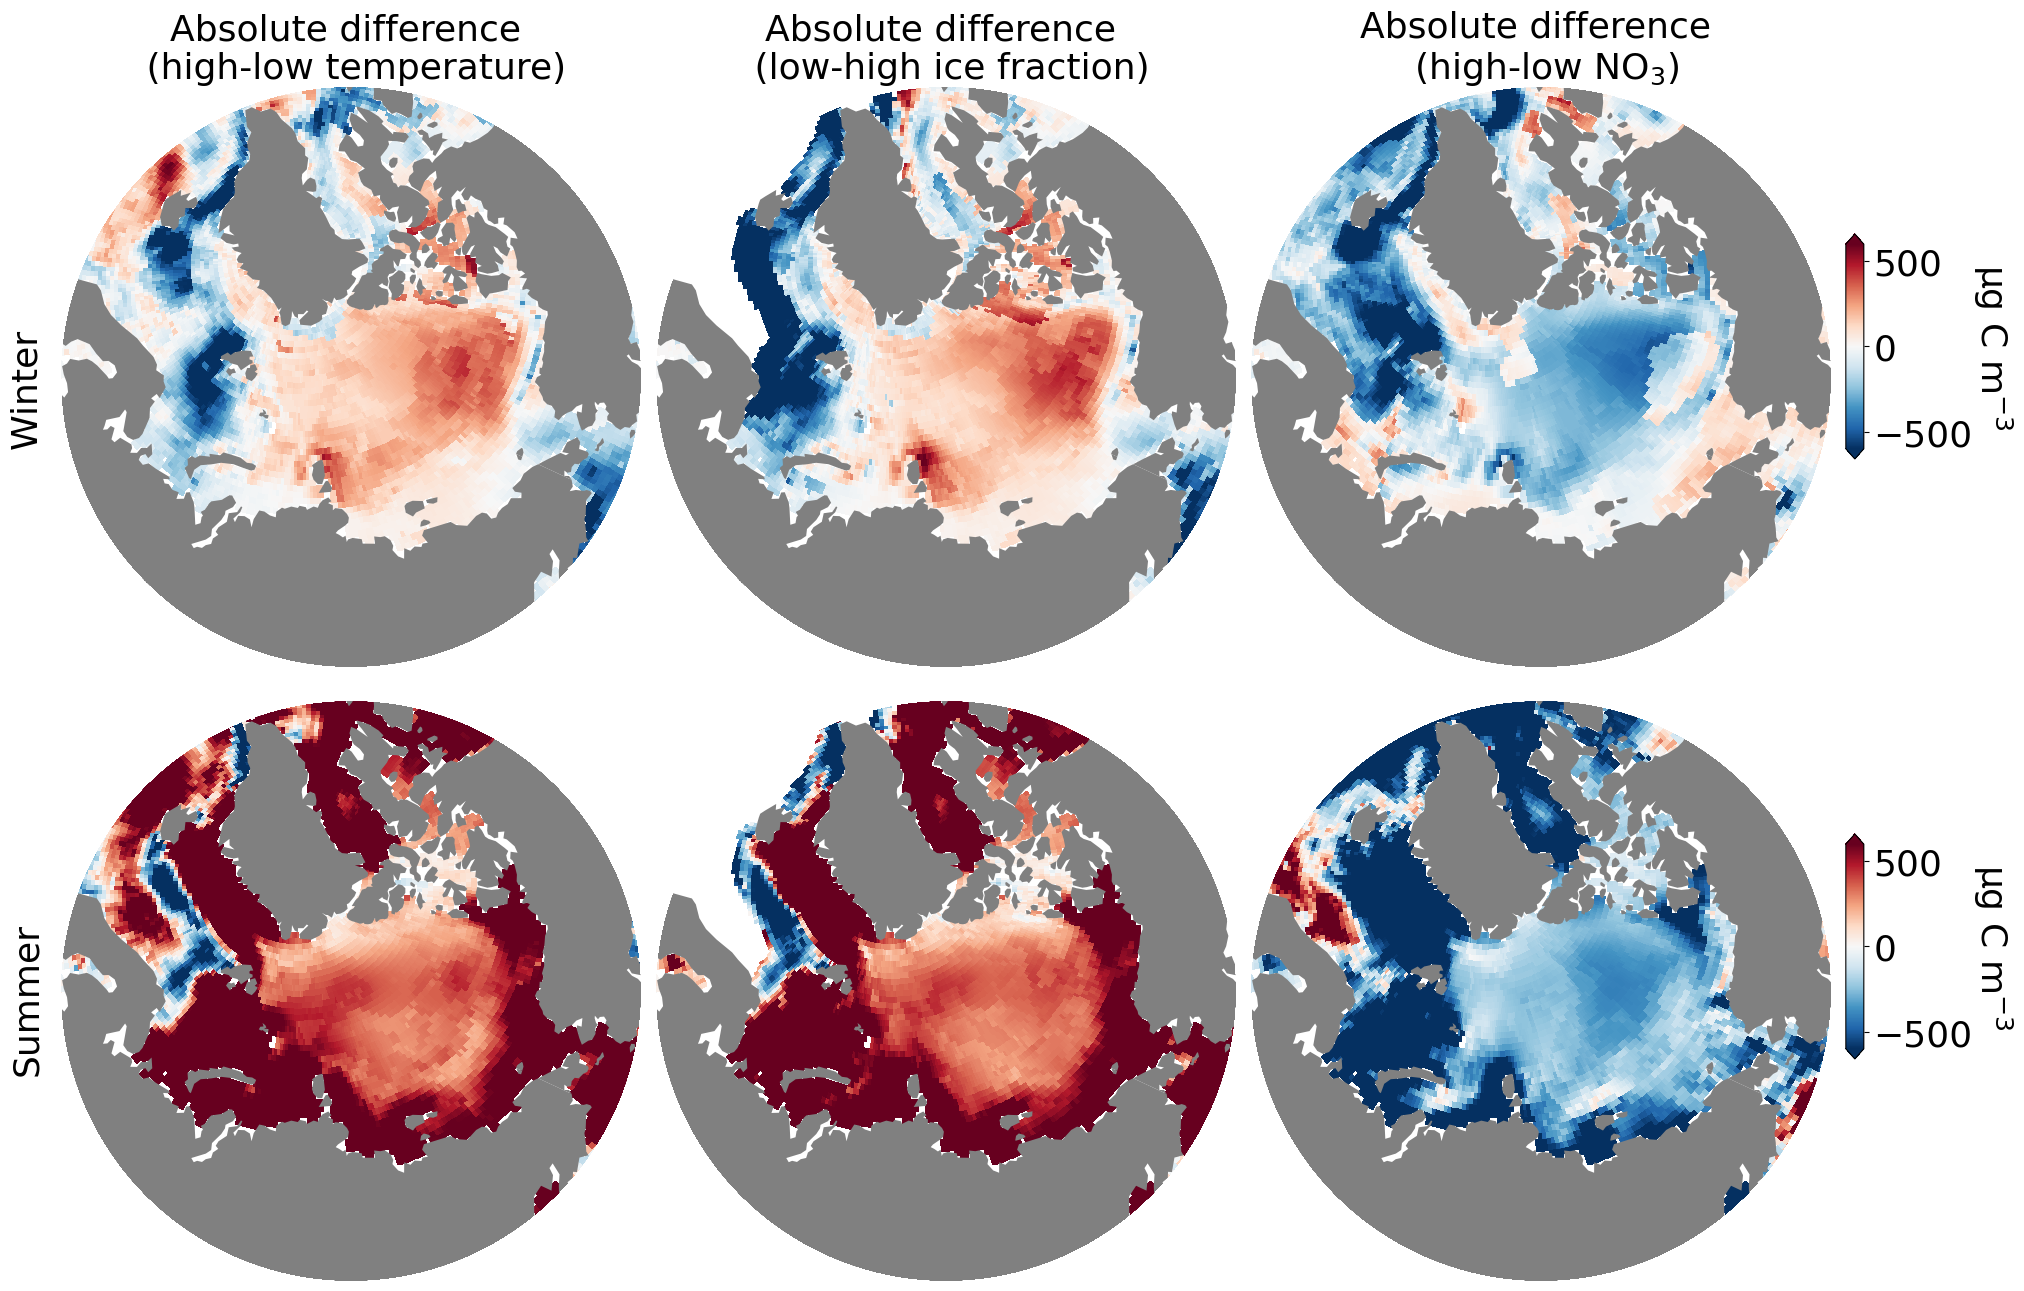

In [47]:
#---------------------------------------------------------------------
fig = plt.figure(figsize=(18, 15))
#---------------------------------------------------------------------
x_lon = dss.TLONG
y_lat= dss.TLAT
font=26

#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())

# -------------  Temperature  ---------------------------------------
vminn = -600
vmaxx = 600
ax = fig.add_subplot(2, 3, 1,projection=my_projn)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_temp_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (high-low temperature)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(2, 3, 4,projection=my_projn)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_temp_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.65, 0.01, 0.15])
cb = fig.colorbar(cf,shrink=0.3, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('$\mu$g C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)

#-------------------------------------------------------------------------
#          Ice Fraction 
#-------------------------------------------------------------------------
ax = fig.add_subplot(2, 3, 2,projection=my_projn)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_ice_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (low-high ice fraction)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(2, 3, 5,projection=my_projn)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_ice_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.25, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.3, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('$\mu$g C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
#-------------------------------------------------------------------------
#           NO3  
#-------------------------------------------------------------------------
ax = fig.add_subplot(2, 3, 3,projection=my_projn)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_no3_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (high-low NO$_3$)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame


ax = fig.add_subplot(2, 3, 6,projection=my_projn)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_no3_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame


plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0001,
    hspace=-0.4)

fig.text(-0.02, 0.7, 'Winter ', va='center', rotation='vertical',fontsize=font)
fig.text(-0.02, 0.29, 'Summer', va='center', rotation='vertical',fontsize=font)
fig.tight_layout()
#-------------------------------------------------------------------------
#                             SAVE FIGURE 
#-------------------------------------------------------------------------
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/summer_winter_zoo_biomass_interannual_percentile_diff_POPgrid.png',dpi=600, bbox_inches='tight')

## Now do the same thing for the trophic level! 

In [63]:
TL_fall = xr.open_mfdataset(f'{file}/zooTL_62yr_fall.nc')
TL_winter = xr.open_mfdataset(f'{file}/zooTL_62yr_winter.nc')
TL_summer = xr.open_mfdataset(f'{file}/zooTL_62yr_summer.nc')
TL_spring=xr.open_mfdataset(f'{file}/zooTL_62yr_spring.nc')

In [65]:
TL_fall.zooTL_fall

<xarray.DataArray 'zooTL_fall' (year: 62, z_t_150m: 15, nlat: 384, nlon: 320)>
dask.array<open_dataset-zooTL_fall, shape=(62, 15, 384, 320), dtype=float64, chunksize=(62, 15, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * year      (year) int64 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60 61
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
  * nlat      (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon      (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

In [58]:
%%time
TL_fall['zooTL_fall'] = xr.concat([TL_fall[v+'TL_fall'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')
TL_summer['zooTL_summer'] = xr.concat([TL_summer[v+'TL_summer'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')
TL_spring['zooTL_spring'] = xr.concat([TL_spring[v+'TL_spring'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')
TL_winter['zooTL_winter'] = xr.concat([TL_winter[v+'TL_winter'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')

CPU times: user 38.7 ms, sys: 0 ns, total: 38.7 ms
Wall time: 45.1 ms


In [66]:
zooTL_summer = np.array(TL_summer.zooTL_summer)
zooTL_spring = np.array(TL_spring.zooTL_spring)
zooTL_witner = np.array(TL_winter.zooTL_winter)
zooTL_fall = np.array(TL_fall.zooTL_fall)

In [67]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([384,320]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([384,320]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([384,320]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([384,320]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([384,320]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([384,320]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([384,320]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([384,320]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))
        high_ice_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))

        low_ice_years_winter[latitude,longitude]= np.nanmean(zooTL_witner[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(zooTL_witner[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
 

CPU times: user 32.8 s, sys: 194 ms, total: 33 s
Wall time: 33.7 s


In [68]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([384,320]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([384,320]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([384,320]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([384,320]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([384,320]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([384,320]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([384,320]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([384,320]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))
        high_no3_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))

        low_no3_years_winter[latitude,longitude]= np.nanmean(zooTL_witner[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(zooTL_witner[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
 

CPU times: user 36.1 s, sys: 805 ms, total: 36.9 s
Wall time: 46.6 s


In [69]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([384,320]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([384,320]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([384,320]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([384,320]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([384,320]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([384,320]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([384,320]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([384,320]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))
        high_temp_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(zooTL_witner[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(zooTL_witner[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))

        low_temp_years_winter[latitude,longitude]= np.nanmean(zooTL_fall[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(zooTL_fall[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
 

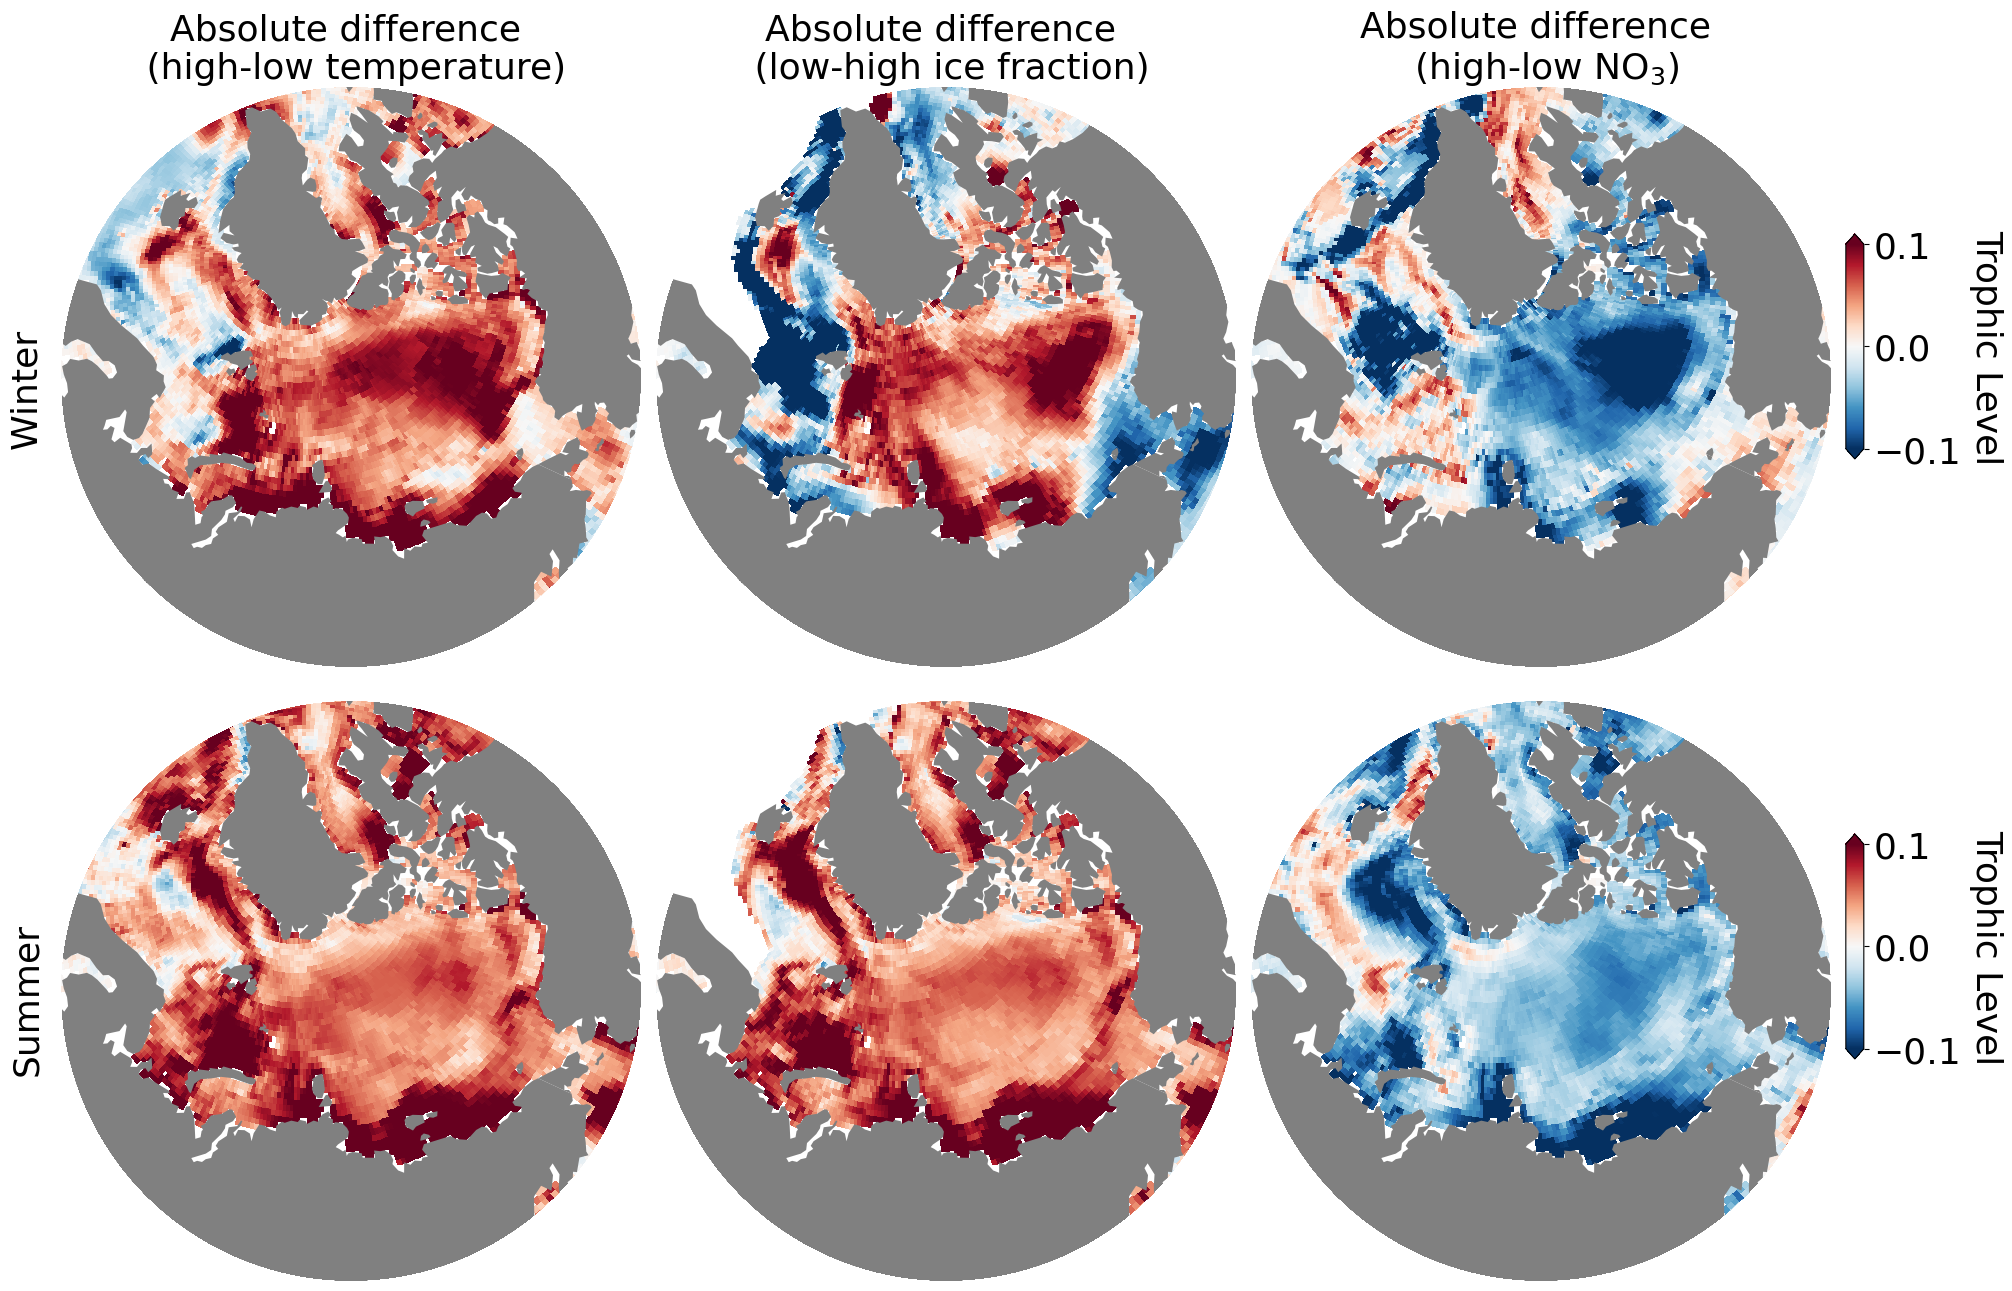

In [71]:
#---------------------------------------------------------------------
fig = plt.figure(figsize=(18, 15))
#---------------------------------------------------------------------
x_lon = dss.TLONG
y_lat= dss.TLAT
font=26

#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())

# -------------  Temperature  ---------------------------------------
vminn =-.1
vmaxx=.1
ax = fig.add_subplot(2, 3, 1,projection=my_projn)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_temp_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (high-low temperature)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(2, 3, 4,projection=my_projn)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_temp_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.65, 0.01, 0.15])
cb = fig.colorbar(cf,shrink=0.3, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('Trophic Level', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)

#-------------------------------------------------------------------------
#          Ice Fraction 
#-------------------------------------------------------------------------
ax = fig.add_subplot(2, 3, 2,projection=my_projn)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_ice_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (low-high ice fraction)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(2, 3, 5,projection=my_projn)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_ice_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.25, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.3, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('Trophic Level', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
#-------------------------------------------------------------------------
#           NO3  
#-------------------------------------------------------------------------
ax = fig.add_subplot(2, 3, 3,projection=my_projn)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
x, y, w_diff = adjust_pop_grid(x_lon, y_lat, winter_no3_diff)
cf = ax.pcolormesh(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Absolute difference \n (high-low NO$_3$)', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame


ax = fig.add_subplot(2, 3, 6,projection=my_projn)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
x, y, s_diff = adjust_pop_grid(x_lon, y_lat, summer_no3_diff)
cf = ax.pcolormesh(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame


plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0001,
    hspace=-0.4)

fig.text(-0.02, 0.7, 'Winter ', va='center', rotation='vertical',fontsize=font)
fig.text(-0.02, 0.29, 'Summer', va='center', rotation='vertical',fontsize=font)
fig.tight_layout()
#-------------------------------------------------------------------------
#                             SAVE FIGURE 
#-------------------------------------------------------------------------
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/summer_winter_TL_interannual_percentile_diff_POPgrid.png',dpi=600, bbox_inches='tight')